# Hybrid Recommender System

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
movies = pd.read_csv('../data/lens_tmdb/cleaned/df_all.csv')
ratings = pd.read_csv('../data/lens_tmdb/ratings_small.csv')

In [3]:
# Prepare data
movies = movies[['movieId', 'genre', 'director']]  # select features to use
data = pd.merge(ratings, movies, on='movieId')
data = data[['userId', 'movieId', 'rating', 'genre', 'director']]

# Label encoding
for col in ['userId', 'movieId', 'genre', 'director']:
    data[col] = LabelEncoder().fit_transform(data[col])

# Train test split
train, test = train_test_split(data)

# Hybrid Model Architecture

In [4]:
# Define model
class HybridModel(nn.Module):
    def __init__(self, n_users, n_movies, n_genres, n_directors, emb_size):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, emb_size)
        self.movie_embedding = nn.Embedding(n_movies, emb_size)
        self.genre_embedding = nn.Embedding(n_genres, emb_size)
        self.director_embedding = nn.Embedding(n_directors, emb_size)
        self.fc = nn.Linear(emb_size*4, 1)

    def forward(self, user, movie, genre, director):
        user_emb = self.user_embedding(user)
        movie_emb = self.movie_embedding(movie)
        genre_emb = self.genre_embedding(genre)
        director_emb = self.director_embedding(director)
        x = torch.cat([user_emb, movie_emb, genre_emb, director_emb], dim=1)
        x = self.fc(x)
        return x

In [32]:
# Create model
model = HybridModel(
    n_users=data['userId'].nunique(),
    n_movies=data['movieId'].nunique(),
    n_genres=data['genre'].nunique(),
    n_directors=data['director'].nunique(),
    emb_size=100  # size of the embedding vectors
)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Tensor Conversion

In [11]:
# Convert data to PyTorch tensors
def to_tensor(df):
    user = torch.tensor(df['userId'].values)
    movie = torch.tensor(df['movieId'].values)
    genre = torch.tensor(df['genre'].values)
    director = torch.tensor(df['director'].values)
    rating = torch.tensor(df['rating'].values)
    return user, movie, genre, director, rating

In [12]:
train_data = to_tensor(train)
test_data = to_tensor(test)

In [13]:
def rmse(predictions, targets):
    return torch.sqrt(((predictions - targets) ** 2).mean())


# Training and Test Loss

In [30]:
import matplotlib.pyplot as plt

# 1. Modify the training loop to save loss and RMSE for each epoch.
train_loss_values = []
train_rmse_values = []
test_loss_values = []

for epoch in range(50):  # number of epochs
    # Training loop
    user, movie, genre, director, rating = train_data
    optimizer.zero_grad()
    outputs = model(user, movie, genre, director).squeeze()
    train_loss = criterion(outputs, rating.float())
    train_loss.backward()
    optimizer.step()

    rmse_value = rmse(outputs, rating.float()).item()
    train_rmse_values.append(rmse_value)
    train_loss_values.append(train_loss.item())

    # Evaluation on test data for each epoch
    with torch.no_grad():
        user, movie, genre, director, rating = test_data
        outputs = model(user, movie, genre, director).squeeze()
        test_loss = criterion(outputs, rating.float()).item()
        test_loss_values.append(test_loss)

    print('Epoch:', epoch, 'Train Loss:', train_loss.item(), 'Test Loss:', test_loss, 'RMSE:', rmse_value)

Epoch: 0 Train Loss: 0.6330101490020752 Test Loss: 0.8636094927787781 RMSE: 0.7956193685531616
Epoch: 1 Train Loss: 0.6330101490020752 Test Loss: 0.8636098504066467 RMSE: 0.7956193685531616
Epoch: 2 Train Loss: 0.6330100893974304 Test Loss: 0.8636099100112915 RMSE: 0.7956193089485168
Epoch: 3 Train Loss: 0.6330100893974304 Test Loss: 0.8636099696159363 RMSE: 0.7956193089485168
Epoch: 4 Train Loss: 0.6330100297927856 Test Loss: 0.8636100888252258 RMSE: 0.7956192493438721
Epoch: 5 Train Loss: 0.6330100297927856 Test Loss: 0.8636102080345154 RMSE: 0.7956192493438721
Epoch: 6 Train Loss: 0.6330099701881409 Test Loss: 0.8636102676391602 RMSE: 0.7956192493438721
Epoch: 7 Train Loss: 0.6330099105834961 Test Loss: 0.8636103868484497 RMSE: 0.7956191897392273
Epoch: 8 Train Loss: 0.6330098509788513 Test Loss: 0.8636104464530945 RMSE: 0.7956191897392273
Epoch: 9 Train Loss: 0.6330098509788513 Test Loss: 0.8636106252670288 RMSE: 0.7956191897392273
Epoch: 10 Train Loss: 0.6330098509788513 Test Loss

# Visualizations

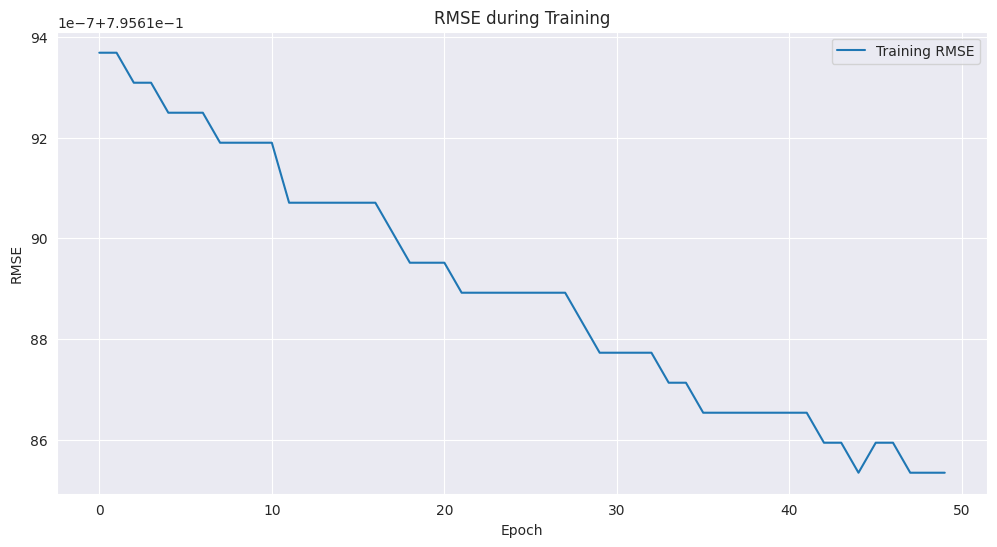

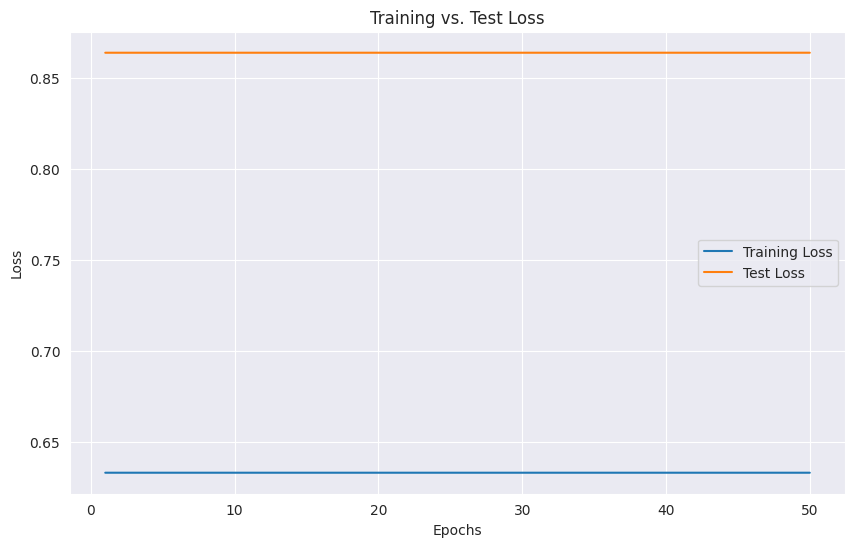

In [31]:
# Visualization 1: RMSE during training
plt.figure(figsize=(12,6))
plt.plot(train_rmse_values, label="Training RMSE")
plt.title("RMSE during Training")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

# Visualization 2: Train and Test Loss over epochs
epochs = list(range(1, 51))
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_values, label="Training Loss")
plt.plot(epochs, test_loss_values, label="Test Loss")
plt.title("Training vs. Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()